In [56]:
%matplotlib notebook
import numpy as np
import pandas as pd
from math import pi
import sys, os
import random
import time
from matplotlib import pyplot as plt
from matplotlib import animation
from sklearn.cluster import DBSCAN
from matplotlib import patches
from sklearn.linear_model import LinearRegression
import math
from matplotlib import transforms

filePath = 'radar_preGFM_C2.txt'
#reading data for the graphing into a data element
data = np.genfromtxt(filePath, delimiter=',', names=True, usecols = (0, 1, 2, 3, 6))

pandata = pd.DataFrame(data, columns=['time', 'track', 'range', 'angle', 'power'])

<IPython.core.display.Javascript object>


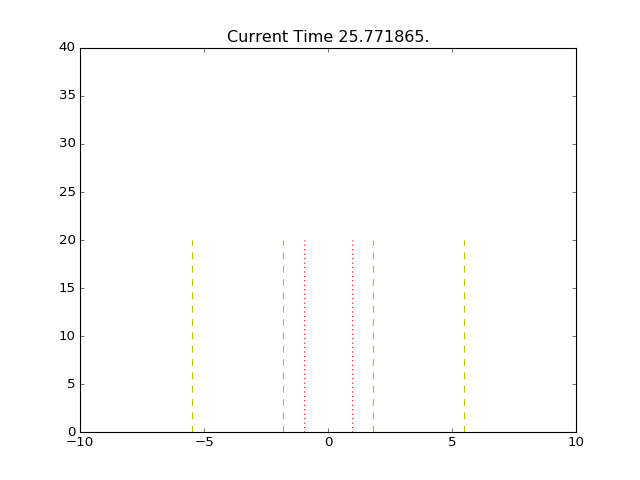

In [244]:
delay = .3
class RegrMagic(object):
    """Mock for function Regr_magic()
    """
    def __init__(self, data):
        self.data = data
    def __call__(self,data):
#         time.sleep(.1)
        toRet = self.data[(self.data['time']>time.time()-startTime-delay)&(self.data['time']<time.time()-startTime)]
        return toRet

nextFrame = RegrMagic(pandata)

def frames():
    while True:
        yield nextFrame(pandata)

fig = plt.figure()
ax = plt.axes(xlim=(-10, 10), ylim=(0, 40))
plt.axvline(x=0.96266, linestyle = 'dotted', ymax = 0.5, color = 'r')
plt.axvline(x=-0.96266, linestyle = 'dotted', ymax = 0.5, color = 'r') 

plt.axvline(x=-1.8288, linestyle = 'dashed', ymax = 0.5, color = 'y')
plt.axvline(x=1.8288, linestyle = 'dashed', ymax = 0.5, color = 'y')

plt.axvline(x=-5.4864, linestyle = 'dashed', ymax = 0.5, color = 'y')
plt.axvline(x=5.4864, linestyle = 'dashed', ymax = 0.5, color = 'y')
scatter = plt.scatter([], [])
startTime = time.time()
boxes = []
def animate(data_slice, scatter,ax,boxes):
#     print(data_slice)
    r = data_slice['range']
    theta = data_slice['angle'] * pi/ 180 + pi/2
    area = data_slice['power'] * 5
    colors = data_slice['track']
    x = -r * np.cos(theta)
    y = r * np.sin(theta)
    temp = pd.DataFrame()
    temp['x'] = x
    temp['y'] = y
    if len(temp)>0:
        filtered = DBSCAN(eps=3,min_samples=5).fit_predict(temp)
    else:
        filtered= []
    temp['filter'] = filtered
    toPrint = pd.DataFrame(columns=['x','y', 'minx', 'miny', 'width', 'height', 'angle'])
    for group in pd.Series(filtered).unique():
        if group>-1:
            subset = temp[temp['filter']==group]
            linReg = LinearRegression().fit(subset['x'].reshape(-1,1),subset['y'])
            rotAngle = np.rad2deg(np.arctan2(linReg.coef_[0],1))
            rotation_matrix = pd.DataFrame(columns=['a','b'])
            rotation_matrix.loc[0] = (math.cos(-math.radians(rotAngle)), -math.sin(-math.radians(rotAngle)))
            rotation_matrix.loc[1] = (math.sin(-math.radians(rotAngle)), math.cos(-math.radians(rotAngle)))
            rotatedSubset = np.matmul(subset[['x','y']].as_matrix(),rotation_matrix.as_matrix())
            rotatedSubset = pd.DataFrame(rotatedSubset, columns=['x','y'])
            toPrint.loc[group] = (subset['x'].mean(), subset['y'].mean(), 
                                  rotatedSubset['x'].min(), rotatedSubset['y'].min(), 
                                  rotatedSubset['x'].max()-rotatedSubset['x'].min(), 
                                  rotatedSubset['y'].max()-rotatedSubset['y'].min(),
                                  rotAngle)
    toRemove = []
    for box in boxes:
        try:
            box.remove()
        except ValueError:
            toRemove.append(box)
    for elem in toRemove:
        boxes.remove(elem)
    plt.draw()
    for piece in toPrint.iterrows():
        row = piece[1]
        box = patches.Rectangle( (row['minx'], row['miny']), row['width'], row['height'], fill=False)
        t = transforms.Affine2D().rotate_deg_around(0,0,-row['angle']) +  ax.transData 
        box.set_transform(t)
        boxes.append(box)
        ax.add_patch(box)
    if len(toPrint)>0:
        scatter.set_offsets(np.vstack((toPrint['x'],toPrint['y'])).T)
        scatter.set_sizes(area)
#     scatter.set_color(colors)
    plt.title("Current Time %f." % (time.time()-startTime))
    return scatter

anim = animation.FuncAnimation(fig, animate,frames=frames, fargs=[scatter,ax,boxes], interval=50, blit=False)
plt.show()